In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, mb_magnitude, iso_calculator, OrbAtt_augment, OrbAtt_augment_loop
import pandas as pd
import os
import pathlib
import string

In [2]:
# defining file
year = '1993'
start_day = '1'
end_day = '365'
Output_Plots = False

In [3]:
# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [4]:
########### INITIALIZING MB & BG ISO vs PARAM HISTOGRAMS ############
max_iso = 1.0
bin_num = 25

iso_bins = np.linspace(0, max_iso, num=bin_num+1)

mag_bins = np.linspace(0, 50000, num=bin_num+1)
MLT_bins = np.linspace(0, 24, num=bin_num+1)
PA_bins = np.linspace(0, 180, num=bin_num+1)
L_bins = np.linspace(3, 8, num=bin_num+1)

###### MICROBURST ISO vs PARAMETERS #######
# Create empty microburst histograms
H_IvMag_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[mag_bins, iso_bins])
H_IvMLT_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, iso_bins])
H_IvPA_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[PA_bins, iso_bins])
H_IvL_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[L_bins, iso_bins])

###### BACKGROUND ISO vs PARAMETERS #######
# Create empty background histograms
H_IvMag_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[mag_bins, iso_bins])
H_IvMLT_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, iso_bins])
H_IvPA_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[PA_bins, iso_bins])
H_IvL_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[L_bins, iso_bins])

In [5]:
for day_of_year in np.arange(int(start_day), int(end_day)+1):
    # name the day
    if len(str(day_of_year)) == 1:
        file = 'hhrr' + year + '00' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 2:
        file = 'hhrr' + year + '0' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 3:
        file = 'hhrr' + year + str(day_of_year) + '.txt'

    # reading in electron counts files:
    t_electrons, r1, r2, r3, r4 = read(year + '_data\\' + file)

    # reading in orbit/attitude data file
    OrbAtt_mask = []
    for i in np.arange(len(OrbAtt_names)):
        OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
    OA_file = OrbAtt_names[OrbAtt_mask][0]
    
    directory = 'D:\SAMPEX_Data\\' + year + '_data\\'
    OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
    # Augment OrbAtt data to fit counts data
    t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)

    # find microburst times and N_100, SSD1, SSD4 counts using algorithm
    t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)

    # create background counts mask
    BG_mask = ~MB_mask

    # calculation of the isotropy indices of electron counts
    iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
    iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

    # find the OrbAtt microburst parameters
    if len(mb_index) > 0:
        t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
        P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
        R_OrbAtt_mb = R_OrbAtt[mb_index]

    # calculation of B_3 bin percentiles
    y_microburst, B_3_microburst, B_3 = mb_magnitude(N_100, N_100_microburst, A_500)
    
    y = N_100 - B_3
    y_background = y[BG_mask]   
    
    ###### MICROBURST ISO vs PARAMETERS #######
    # Create histograms for day #
    if len(mb_index) > 0:
        
        H_IvMag_MB_day, _, _ = np.histogram2d(y_microburst, iso_indices_MB, bins=[mag_bins, iso_bins])
        H_IvMLT_MB_day, _, _ = np.histogram2d(MLT_OrbAtt_mb, iso_indices_MB, bins=[MLT_bins, iso_bins])
        H_IvPA_MB_day, _, _ = np.histogram2d(P_OrbAtt_mb, iso_indices_MB, bins=[PA_bins, iso_bins])
        H_IvL_MB_day, _, _ = np.histogram2d(LS_OrbAtt_mb, iso_indices_MB, bins=[L_bins, iso_bins])
    
        # Add histograms for day # to cumulative histograms
        H_IvMag_MB += H_IvMag_MB_day
        H_IvMLT_MB += H_IvMLT_MB_day
        H_IvPA_MB += H_IvPA_MB_day
        H_IvL_MB += H_IvL_MB_day
    
    ###### BACKGROUND ISO vs PARAMETERS #######
    # Create histograms for day #
    H_IvMag_BG_day, _, _ = np.histogram2d(y_background, iso_indices_BG, bins=[mag_bins, iso_bins])
    H_IvMLT_BG_day, _, _ = np.histogram2d(MLT_OrbAtt[BG_mask], iso_indices_BG, bins=[MLT_bins, iso_bins])
    H_IvPA_BG_day, _, _ = np.histogram2d(P_OrbAtt[BG_mask], iso_indices_BG, bins=[PA_bins, iso_bins])
    H_IvL_BG_day, _, _ = np.histogram2d(LS_OrbAtt[BG_mask], iso_indices_BG, bins=[L_bins, iso_bins])
    
    # Add histograms for day # to cumulative histograms
    H_IvMag_BG += H_IvMag_BG_day
    H_IvMLT_BG += H_IvMLT_BG_day
    H_IvPA_BG += H_IvPA_BG_day
    H_IvL_BG += H_IvL_BG_day

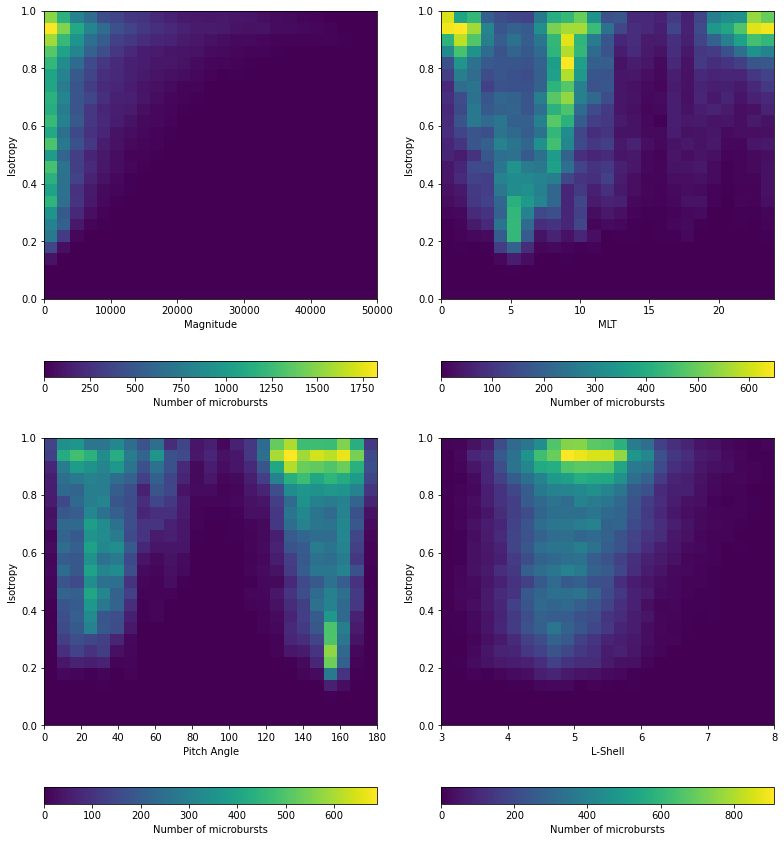

In [6]:
###### MICROBURST ISO vs PARAMETERS #######
# Make the four plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag_MB = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_MB.T, vmin=0)
plt.colorbar(p_IvMag_MB, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT_MB = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT_MB.T, vmin=0)
plt.colorbar(p_IvMLT_MB, ax=ax[0,1], orientation='horizontal', label='Number of microbursts')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA_MB = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA_MB.T, vmin=0)
plt.colorbar(p_IvPA_MB, ax=ax[1,0], orientation='horizontal', label='Number of microbursts')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_IvL_MB = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL_MB.T, vmin=0)
plt.colorbar(p_IvL_MB, ax=ax[1,1], orientation='horizontal', label='Number of microbursts')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

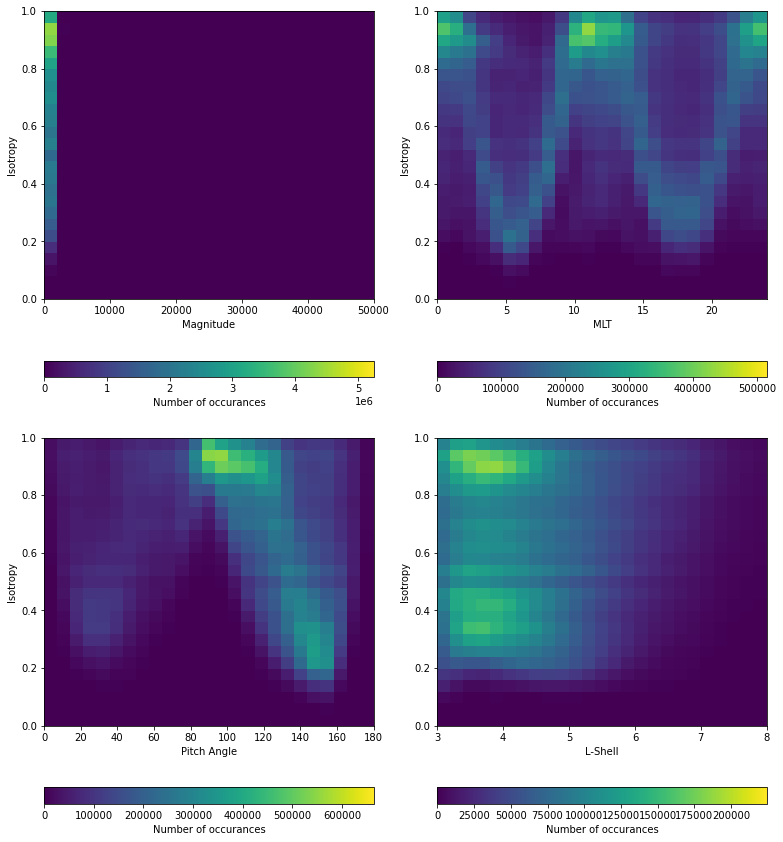

In [7]:
###### BACKGROUND ISO vs PARAMETERS #######
# Make the four plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag_BG = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_BG.T, vmin=0, vmax=np.max(H_IvMag_BG)*1.2)
plt.colorbar(p_IvMag_BG, ax=ax[0,0], orientation='horizontal', label='Number of occurances')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT_BG = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT_BG.T, vmin=0, vmax=np.max(H_IvMLT_BG)*1.2)
plt.colorbar(p_IvMLT_BG, ax=ax[0,1], orientation='horizontal', label='Number of occurances')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA_BG = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA_BG.T, vmin=0, vmax=np.max(H_IvPA_BG)*1.2)
plt.colorbar(p_IvPA_BG, ax=ax[1,0], orientation='horizontal', label='Number of occurances')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_IvL_BG = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL_BG.T, vmin=0, vmax=np.max(H_IvL_BG)*1.2)
plt.colorbar(p_IvL_BG, ax=ax[1,1], orientation='horizontal', label='Number of occurances')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

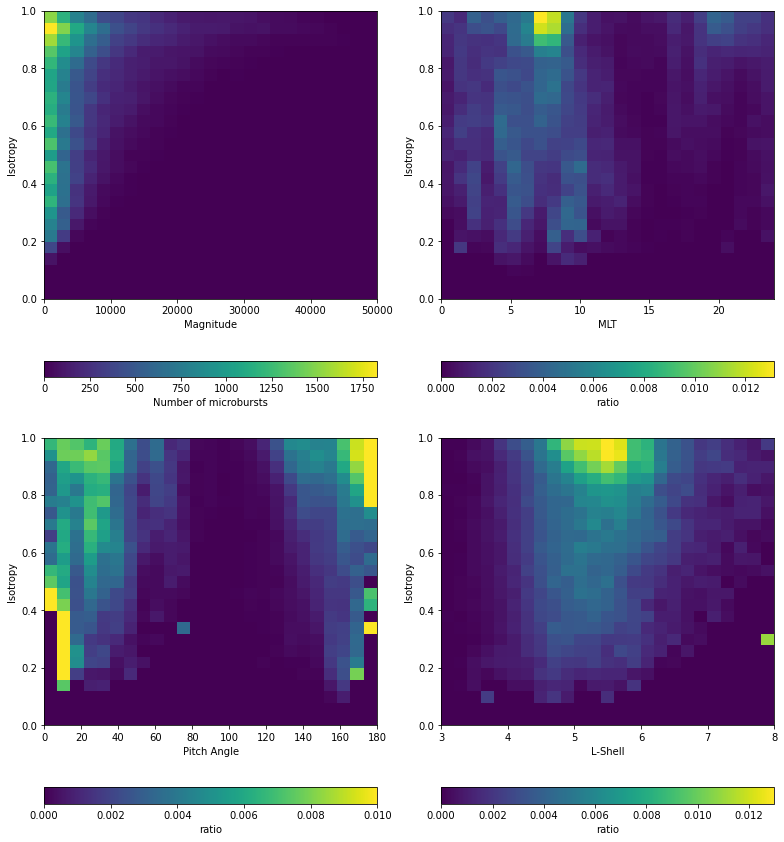

In [17]:
ratio_MLT = H_IvMLT_MB / (H_IvMLT_BG+1)
ratio_PA = H_IvPA_MB / (H_IvPA_BG+1)
ratio_L = H_IvL_MB / (H_IvL_BG+1)

ratio_MLT_T = H_IvMLT_MB / (H_IvMLT_BG+H_IvMLT_MB+1)
ratio_PA_T = H_IvPA_MB / (H_IvPA_BG+H_IvPA_MB+1)
ratio_L_T = H_IvL_MB / (H_IvL_BG+H_IvL_MB+1)

diff_MLT = H_IvMLT_BG - H_IvMLT_MB
diff_PA = H_IvPA_BG - H_IvPA_MB
diff_L = H_IvL_BG - H_IvL_MB


_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag_MB = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_MB.T, vmin=0)
plt.colorbar(p_IvMag_MB, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_ratio_MLT = ax[0,1].pcolormesh(MLT_bins, iso_bins, ratio_MLT.T, vmin=0)
plt.colorbar(p_ratio_MLT, ax=ax[0,1], orientation='horizontal', label='ratio')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_ratio_PA = ax[1,0].pcolormesh(PA_bins, iso_bins, ratio_PA.T, vmin=0, vmax=0.01)
plt.colorbar(p_ratio_PA, ax=ax[1,0], orientation='horizontal', label='ratio')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_ratio_L = ax[1,1].pcolormesh(L_bins, iso_bins, ratio_L.T, vmin=0)
plt.colorbar(p_ratio_L, ax=ax[1,1], orientation='horizontal', label='ratio')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()